In [1]:
import numpy as np
import _pickle as pkl
import torch
%matplotlib inline 
import matplotlib.pyplot as plt
import os, sys, time
sys.path.append('../..')
from utils import set_seed_torch, rgb2gray
set_seed_torch(3)
from argparse import Namespace
import json
from utils2 import load_vh_models, frame_stack
import torch.nn as nn
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from models import ProductOfExperts
import gzip

In [2]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
args = ObjectView({
 'res': 64,
 'dataset_path': ['/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/{}'
                   .format("vha1_2D_len16_oscxy_withGT_0B7AB071F98942578ABDA66879290F2F.pkl"),
                  '/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/{}'
                   .format("vha2_2D_len16_oscxy_withGT_3502DE81F7C343FB8B57FA92FDECF4DA.pkl"),
                  '/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/{}'
                   .format("vha3_2D_len16_oscxy_withGT_5DB32B21A6AA4E5892D2F6B8F40EF9E6.pkl")
                 ],
 'models_dir': '/home/olimoyo/visual-haptic-dynamics/saved_models/{}'
                   .format("vh"),
#  'dataset_path': ['/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/mit_push/{}'
#                    .format("min-tr2.5_min-rot0.5_len48.pkl")
#                  ],
#  'models_dir': '/home/olimoyo/visual-haptic-dynamics/saved_models/{}'
#                    .format("mit"),
 'device': 'cuda:1',
 'up_to_n_pred': 12,
 'n_initial': 2,
 'n_final': 2
})

def load_models_dir(models_dir):
    """Load hyperparameters from trained model."""
    dict_of_models = {}
    for filedir in os.listdir(models_dir):
        fullpath = os.path.join(models_dir, filedir)
        if os.path.isdir(fullpath):
            with open(os.path.join(fullpath, 'hyperparameters.txt'), 'r') as fp:
                dict_of_models[fullpath] = Namespace(**json.load(fp))
    return dict_of_models

def is_gz_file(filepath):
    with open(filepath, 'rb') as test_f:
        return test_f.read(2) == b'\x1f\x8b'
    
data = {
#     'img_rgb': [],
    'img_gray': [],
    'haptic': [],
    'arm': [],
    'actions': []
}

for dataset_path in args.dataset_path:
    if is_gz_file(dataset_path):
        with gzip.open(dataset_path, 'rb') as f:
            raw_data = pkl.load(f)
    else:
        with open(dataset_path, 'rb') as f:
            raw_data = pkl.load(f)

#     data['img_rgb'].append(torch.from_numpy(raw_data["img"].transpose(0, 1, 4, 2, 3)).int().to(device=args.device))
    data['img_gray'].append(torch.from_numpy(rgb2gray(raw_data["img"]).transpose(0, 1, 4, 2, 3)).float().to(device=args.device))
    data['haptic'].append(torch.from_numpy(raw_data['ft']).float().to(device=args.device))
    data['arm'].append(torch.from_numpy(raw_data['arm']).float().to(device=args.device))
    data['actions'].append(torch.from_numpy(raw_data["action"]).to(device=args.device).float())

data = {k:torch.cat(v, dim=0) for k,v in data.items()}

In [3]:
dict_of_models = load_models_dir(args.models_dir)
analysis_data = {}

with torch.no_grad():
    for path, model_args in dict_of_models.items():
        
        model_name = path.split("/")[-1]
        nets = load_vh_models(path=path, args=model_args, mode='eval', device=args.device)
        
        # Use validation indices only
        with open(os.path.join(path, "val_idx.pkl"), 'rb') as f:
            val_idx = pkl.load(f)
        data_val = {k:v[val_idx] for k,v in data.items()}
    
        if model_args.context_modality != "none":
            poe = ProductOfExperts()
            
        def encode(x_img, x_context):
            # Encode
            z_img, mu_z_img, logvar_z_img = nets["img_enc"](x_img.reshape(-1, *x_img.shape[2:]))
            
            if model_args.context_modality != "none":
                _, mu_z_context, logvar_z_context = nets["context_enc"](x_context.reshape(-1, *x_context.shape[2:]))
                # Mix modalities with product of experts
                mu_z_obs_enc, logvar_z_obs_enc  = poe(
                    mu=torch.cat((
                        mu_z_img.unsqueeze(1), 
                        mu_z_context.unsqueeze(1)
                    ), axis=1),
                    logvar=torch.cat((
                        logvar_z_img.unsqueeze(1), 
                        logvar_z_context.unsqueeze(1)
                    ), axis=1), 
                )

                std_z_obs_enc = torch.exp(logvar_z_obs_enc / 2.0)
                eps = torch.randn_like(std_z_obs_enc)
                z_obs_enc = mu_z_obs_enc + eps * std_z_obs_enc
            else:
                # If only image is used
                z_obs_enc, mu_z_obs_enc, logvar_z_obs_enc = \
                    z_img, mu_z_img, logvar_z_img
    
            if model_args.context == "none":
                # If only CNN is used for recognition, process in batch instead of roll out
                var_z_obs_enc = torch.diag_embed(torch.exp(logvar_z_obs_enc))
                # Group sample, mean, covariance
                q_z_i = {"z": z_obs_enc, "mu": mu_z_obs_enc, "cov": var_z_obs_enc}
            elif model_args.context == "ssm" or "rssm":
                q_z_i = {
                    "z": torch.empty((n, l, model_args.dim_z), device=device),
                    "mu": torch.empty((n, l, model_args.dim_z), device=device),
                    "cov": torch.empty((n, l, model_args.dim_z, model_args.dim_z), device=device)
                }

                z_cat_enc = z_obs_enc.reshape(
                    n, l, *z_obs_enc.shape[1:]
                ).transpose(1,0)

                z_0 =torch.zeros(
                    model_args.dim_z, 
                    requires_grad=False, 
                    device=device
                ).repeat(n, 1)

                if model_args.context == "rssm":
                    h_0 = None

                # Roll out
                for ii in range(l):
                    if model_args.context == "ssm":
                        inp = z_0
                    elif model_args.context == "rssm":
                        z_0 = z_0.unsqueeze(0)
                        out, h = nets["rssm_enc"](z_0, h_0)
                        inp = out[0]
                        h_0 = h

                    z, mu_z, logvar_z = nets["mix"](
                        torch.cat((inp, z_cat_enc[ii]), axis=-1)
                    )
                    var_z = torch.diag_embed(torch.exp(logvar_z))
                    q_z_i["z"][:, ii] = z 
                    q_z_i["mu"][:, ii] = mu_z
                    q_z_i["cov"][:, ii] = var_z
                    z_0 = z

                q_z_i = {k:v.reshape(-1, *v.shape[2:]) for k, v in q_z.items()}
            
            return q_z_i
    
#         if model_args.dim_x[0] == 1:
#             imgs = data['img_gray']
#         elif model_args.dim_x[0] == 3:
#             imgs = data['img_rgb']
        img_key = 'img_gray'

        T = model_args.frame_stacks

        assert args.n_initial + args.up_to_n_pred <= data_val[img_key].shape[1]
        assert args.n_initial > T
        
        analysis_data[model_name] = {}
        for n_pred in range(1, args.up_to_n_pred + 1):
            analysis_data[model_name][f"{n_pred}_pred"] = {}
            analysis_data[model_name][f"{n_pred}_pred"]["MSE_x"] = {"mu": 0, "std": 0}
            analysis_data[model_name][f"{n_pred}_pred"]["MSE_z"] = {"mu": 0, "std": 0}
            analysis_data[model_name][f"{n_pred}_pred"]["SSIM"] = {"mu": 0, "std": 0}
            analysis_data[model_name][f"{n_pred}_pred"]["PSNR"] = {"mu": 0, "std": 0}
            
            u = data_val['actions']
            
            # Sequence of initial images
            x_img_i = data_val[img_key][:, :args.n_initial] 
            x_img_i = frame_stack(x_img_i, frames=T)

            # Sequence of ground truth images
            x_img_gt = data_val[img_key][:, (args.n_initial + n_pred - args.n_final):(args.n_initial + n_pred)]
            x_img_gt = frame_stack(x_img_gt, frames=T)

            # Sequence of initial extra modalities
            x_ft_i = data_val['haptic'][:, T:args.n_initial] / model_args.ft_normalization
            x_arm_i = data_val['arm'][:, T:args.n_initial]               
            
            if model_args.context_modality == "joint":
                x_context_i = torch.cat((x_ft_i, x_arm_i), dim=-1).transpose(-1, -2)
            elif model_args.context_modality == "ft":
                x_context_i = x_ft_i.transpose(-1, -2)
            elif model_args.context_modality == "arm":
                x_context_i = x_arm_i.transpose(-1, -2)
            elif model_args.context_modality == "none":
                x_context_i = None
            
            # Sequence of gt extra modalities
            x_ft_gt = data_val['haptic'][:, (args.n_initial + n_pred - args.n_final + T):(args.n_initial + n_pred)] / model_args.ft_normalization
            x_arm_gt = data_val['arm'][:, (args.n_initial + n_pred - args.n_final + T):(args.n_initial + n_pred)]

            if model_args.context_modality == "joint":
                x_context_gt = torch.cat((x_ft_gt, x_arm_gt), dim=-1).transpose(-1, -2)
            elif model_args.context_modality == "ft":
                x_context_gt = x_ft_gt.transpose(-1, -2)
            elif model_args.context_modality == "arm":
                x_context_gt = x_arm_gt.transpose(-1, -2)
            elif model_args.context_modality == "none":
                x_context_gt = None
                
            n, l = x_img_i.shape[0], x_img_i.shape[1] 
            l_gt = x_img_gt.shape[1]
            
            q_z_i = encode(x_img_i, x_context_i)
            q_z_g = encode(x_img_gt, x_context_gt)
            z_gt = q_z_g["mu"]
            z_gt = z_gt.reshape(n, l_gt, -1)[:, -1]
            
            # Group and prepare for prediction
            q_z_i = {k:v.reshape(n, l, *v.shape[1:]).transpose(1,0) for k, v in q_z_i.items()}
            u = u.transpose(1,0)

            # First run
            z_i, mu_z_i, var_z_i = q_z_i["z"], q_z_i["mu"], q_z_i["cov"]
            u_i = u[(T + 1):(1 + args.n_initial)]
            h_i = None

            # Predict
            for jj in range(0, n_pred):
                z_ip1, mu_z_ip1, var_z_ip1, h_ip1 = nets["dyn"](
                    z_t=z_i, 
                    mu_t=mu_z_i, 
                    var_t=var_z_i, 
                    u=u_i, 
                    h_0=h_i, 
                    single=False
                )
                z_hat = mu_z_ip1[-1]
                z_i, mu_z_i, var_z_i, h_i = z_ip1[-1:], mu_z_ip1[-1:], var_z_ip1[-1:], h_ip1
                u_i = u[1 + args.n_initial + jj][None]
            
            # Decode 
            x_hat = nets["img_dec"](z_hat)
            x_hat = x_hat[:, 0].view(x_hat.shape[0], -1)
            x_img_gt = x_img_gt[:, -1, 0].view(x_img_gt.shape[0], -1)
            
            # Move to cpu, np
            x_hat = x_hat.cpu().numpy()
            z_hat = z_hat.cpu().numpy()
            x_img_gt = x_img_gt.cpu().numpy()
            z_gt = z_gt.cpu().numpy()
            
            batch_mse_img = np.sum(((x_img_gt - x_hat)**2), axis=-1)
            batch_mse_z = np.sum(((z_gt - z_hat)**2), axis=-1)
            print("prediction length", n_pred, "starting position", T,
                "mean mse img: ", batch_mse_img.mean(),
                "std mse img: ", batch_mse_img.std(),
                "mean mse latent: ", batch_mse_z.mean(),
                "std mse latent: ", batch_mse_z.std())

            analysis_data[model_name][f"{n_pred}_pred"]["MSE_x"]["mu"] = batch_mse_img.mean()
            analysis_data[model_name][f"{n_pred}_pred"]["MSE_x"]["std"] = batch_mse_img.std()
            analysis_data[model_name][f"{n_pred}_pred"]["MSE_z"]["mu"] = batch_mse_z.mean()
            analysis_data[model_name][f"{n_pred}_pred"]["MSE_z"]["std"] = batch_mse_z.std()


            batch_ssim = []
            batch_psnr = []
            for jj in range(n):
                batch_ssim.append(ssim(
                    x_img_gt[jj].reshape(64,64), 
                    x_hat[jj].reshape(64,64), 
                    data_range=1.0
                ))
                batch_psnr.append(psnr(
                    x_img_gt[jj].reshape(64,64), 
                    x_hat[jj].reshape(64,64), 
                    data_range=1.0
                ))
            batch_ssim = np.array(batch_ssim)
            batch_psnr = np.array(batch_psnr)

            analysis_data[model_name][f"{n_pred}_pred"]["SSIM"]["mu"] = batch_ssim.mean()
            analysis_data[model_name][f"{n_pred}_pred"]["SSIM"]["std"] = batch_ssim.std()
            analysis_data[model_name][f"{n_pred}_pred"]["PSNR"]["mu"] = batch_psnr.mean()
            analysis_data[model_name][f"{n_pred}_pred"]["PSNR"]["std"] = batch_psnr.std()


    print("DONE!")

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vh/1465883_nstep2_reproduce_1024optbase_noAnnealkl_yesWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_vha_r1.00_kl1.00_lr3e4
prediction length 1 starting position 1 mean mse img:  0.2497952 std mse img:  0.49961865 mean mse latent:  3.3312547 std mse latent:  24.140049
prediction length 2 starting position 1 mean mse img:  0.5148292 std mse img:  0.6701853 mean mse latent:  0.08422015 std mse latent:  0.19120596
prediction length 3 starting position 1 mean mse img:  0.89410096 std mse img:  0.9550299 mean mse latent:  0.13322724 std mse latent:  0.38186467
prediction length 4 starting position 1 mean mse img:  1.3441939 std mse img:  1.3800037 mean mse latent:  0.23954907 std mse latent:  0.9174758
prediction length 5 starting position 1 mean mse img:  1.8276765 std mse img:  1.8475095 mean mse latent:  0.46262106 std mse latent:  2.1047406
prediction length 6 starting position 1 mean mse img:  2.26

1465883_nstep2_reproduce_1024optbase_noAnnealkl_yesWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_vha_r1.00_kl1.00_lr3e4
1485221_nstep2_1024optbase_noAnnealkl_yesWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_va_r1.00_kl1.00_lr3e4
1485220_nstep2_1024optbase_noAnnealkl_yesWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_vh_r1.00_kl1.00_lr3e4
1465882_nstep2_reproduce_1024optbase_noAnnealkl_yesWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_v_r1.00_kl1.00_lr3e4


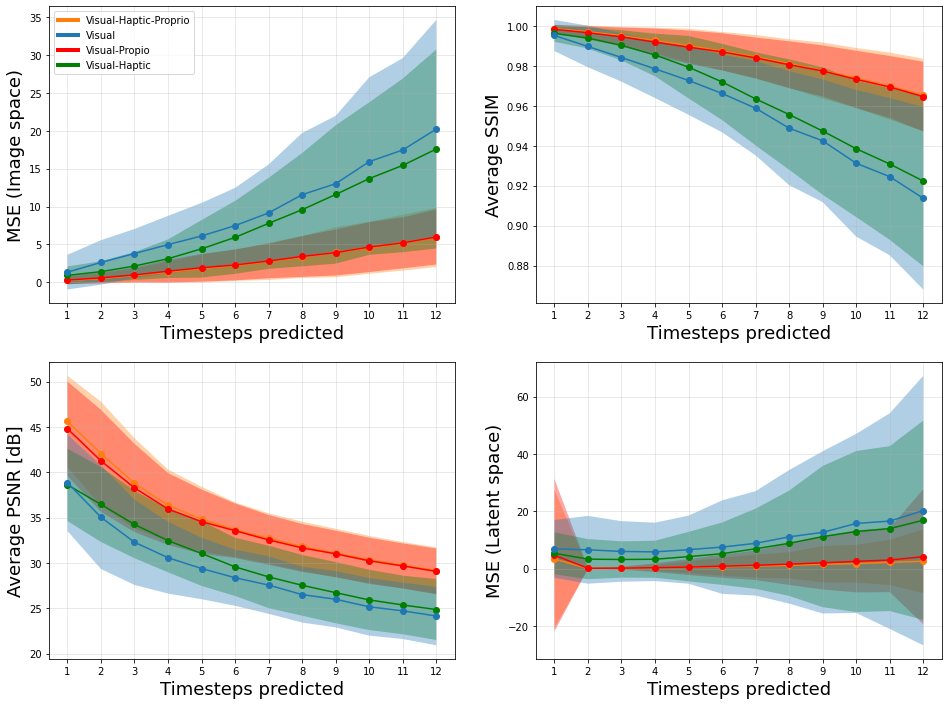

In [5]:
from matplotlib.lines import Line2D

def add_data_to_plot(name, data, var=True):
    if "_vha_" in name:
        color = '#ff7f0e'
    elif "_v_" in name:
        color = '#1f77b4'
    elif "_va_" in name:
        color = 'red'
    elif "_vh_" in name:
        color = 'green'
    elif "prior_expert" in name:
        return
        
    if "nstep2" in name:
        marker = "o"
    else:
        marker = "x"
    
    plot_data = {'MSE_x': {"mu":[], "std":[]}, 
                 'SSIM': {"mu":[], "std":[]}, 
                 'PSNR': {"mu":[], "std":[]}, 
                 "MSE_z": {"mu":[], "std":[]}}
    for k, v in data.items():
        plot_data['MSE_x']["mu"].append(v['MSE_x']["mu"])
        plot_data['MSE_x']["std"].append(v['MSE_x']["std"])
        plot_data['SSIM']["mu"].append(v['SSIM']["mu"])
        plot_data['SSIM']["std"].append(v['SSIM']["std"])
        plot_data['PSNR']["mu"].append(v['PSNR']["mu"])
        plot_data['PSNR']["std"].append(v['PSNR']["std"])
        plot_data['MSE_z']["mu"].append(v['MSE_z']["mu"])
        plot_data['MSE_z']["std"].append(v['MSE_z']["std"])

    custom_lines = [Line2D([0], [0], color='#ff7f0e', lw=4),
                    Line2D([0], [0], color='#1f77b4', lw=4),
                    Line2D([0], [0], color='red', lw=4),
                    Line2D([0], [0], color='green', lw=4),
                    Line2D([0], [0], color='black', lw=1, marker="o"),
                    Line2D([0], [0], color='black', lw=1, marker="x")]

    axs[0,0].legend(
        custom_lines, 
        ['Visual-Haptic-Proprio',
         'Visual',
         'Visual-Propio',
         'Visual-Haptic'], 
        loc='upper left'
    )

    axs[0,0].plot(
        list(range(1, len(plot_data['MSE_x']["mu"]) + 1)), 
        plot_data['MSE_x']["mu"],
        color=color, 
        marker=marker,
    )
    if var:
        axs[0,0].fill_between(
            list(range(1, len(plot_data['MSE_x']["mu"]) + 1)), 
            [a_i + b_i for a_i, b_i in zip(plot_data['MSE_x']["mu"], plot_data['MSE_x']["std"])],
            [a_i - b_i for a_i, b_i in zip(plot_data['MSE_x']["mu"], plot_data['MSE_x']["std"])],
            facecolor=color, 
            alpha=0.35
        )
    axs[0,1].plot(
        list(range(1, len(plot_data['SSIM']["mu"]) + 1)), 
        plot_data['SSIM']["mu"],
        color=color, 
        marker=marker
    )
    if var:
        axs[0,1].fill_between(
            list(range(1, len(plot_data['SSIM']["mu"]) + 1)), 
            [a_i + b_i for a_i, b_i in zip(plot_data['SSIM']["mu"], plot_data['SSIM']["std"])],
            [a_i - b_i for a_i, b_i in zip(plot_data['SSIM']["mu"], plot_data['SSIM']["std"])],
            facecolor=color, 
            alpha=0.35
        )
        
    axs[1,0].plot(
        list(range(1, len(plot_data['PSNR']["mu"]) + 1)), 
        plot_data['PSNR']["mu"],
        color=color,
        marker=marker
    )
    if var:
        axs[1,0].fill_between(
            list(range(1, len(plot_data['PSNR']["mu"]) + 1)), 
            [a_i + b_i for a_i, b_i in zip(plot_data['PSNR']["mu"], plot_data['PSNR']["std"])],
            [a_i - b_i for a_i, b_i in zip(plot_data['PSNR']["mu"], plot_data['PSNR']["std"])],
            facecolor=color, 
            alpha=0.35
        )
    axs[1,1].plot(
        list(range(1, len(plot_data['MSE_z']["mu"]) + 1)), 
        plot_data['MSE_z']["mu"],
        color=color,
        marker=marker
    )
    if var:
        axs[1,1].fill_between(
            list(range(1, len(plot_data['MSE_z']["mu"]) + 1)), 
            [a_i + b_i for a_i, b_i in zip(plot_data['MSE_z']["mu"], plot_data['MSE_z']["std"])],
            [a_i - b_i for a_i, b_i in zip(plot_data['MSE_z']["mu"], plot_data['MSE_z']["std"])],
            facecolor=color, 
            alpha=0.35
        )
    
    for ii in range(axs.shape[0]):
        for jj in range(axs.shape[1]):
            axs[ii, jj].set_xlabel("Timesteps predicted", fontsize=18)
            axs[ii, jj].set_xticks(np.arange(1, args.up_to_n_pred + 1, 1.0))
            axs[ii, jj].grid(alpha=0.35, linestyle='solid', axis='both')

    axs[0, 0].set_ylabel("MSE (Image space)", fontsize=18)
    axs[0, 1].set_ylabel("Average SSIM", fontsize=18)
    axs[1, 0].set_ylabel("Average PSNR [dB]", fontsize=18)
    axs[1, 1].set_ylabel("MSE (Latent space)", fontsize=18)

fig, axs = plt.subplots(2, 2, figsize=(16,12))
for k, v in analysis_data.items():
    print(k)
    add_data_to_plot(k, v, var=True)